# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. Generate Training Image

* Read this paper to understand their approach https://arxiv.org/pdf/1703.02442.pdf
* Start small (use a single slide, at the lowest available zoom level - the effective resolution should be on the order of 1,000 by 1,000 pixels).
* Write code to slide a window across the slide. Extract patches and labels (using the tissue mask).

## 1.1. Import data

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# list all the slides provided by professor
!ls '/content/drive/My Drive/project-adl/slides'

tumor_001_mask.tif  tumor_019.tif	tumor_064_mask.tif  tumor_091.tif
tumor_001.tif	    tumor_023_mask.tif	tumor_064.tif	    tumor_094_mask.tif
tumor_002_mask.tif  tumor_023.tif	tumor_075_mask.tif  tumor_094.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_075.tif	    tumor_096_mask.tif
tumor_005_mask.tif  tumor_031.tif	tumor_078_mask.tif  tumor_096.tif
tumor_005.tif	    tumor_035_mask.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_012_mask.tif  tumor_035.tif	tumor_081_mask.tif  tumor_101.tif
tumor_012.tif	    tumor_057_mask.tif	tumor_081.tif	    tumor_110_mask.tif
tumor_016_mask.tif  tumor_057.tif	tumor_084_mask.tif  tumor_110.tif
tumor_016.tif	    tumor_059_mask.tif	tumor_084.tif
tumor_019_mask.tif  tumor_059.tif	tumor_091_mask.tif


In [14]:
train_list = ['078','084','091','101','110'] 
test_list = ['016','031']
slide_list = train_list + test_list
print(slide_list)

['078', '084', '091', '101', '110', '016', '031']


## 1.2. Generate images of all slides at level 7

In [0]:
#slide_id='091'
for slide_id in slides_list:
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print("Read WSI from %s includes %d levels" %(slide_path,len(slide.level_dimensions)))
  tumor_mask = open_slide(tumor_mask_path)
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])[:,:,0]
  fig = plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  filename = 'drive/My Drive/project-adl/image_lev7/image_lev7_%s.png' %slide_id
  plt.imshow(mask_image, cmap='jet', alpha=0.5) 
  fig.savefig(filename)
  

## 1.3. Generate training patches and corresponding labels

Sample from only center 10%-90% region to avoid boundary effect.

###  General Params

In [0]:
# Set patches as 299*299 in lev3/4, check center 128*128 at lev 3 for labeling.
input_size = 299
tumor_check_size = 128
bound = (input_size - 1)/2

In [7]:
down_factor = dict()
for i in range(8):
  down_factor[i] = 2**i
print(down_factor)

{0: 1, 1: 2, 2: 4, 3: 8, 4: 16, 5: 32, 6: 64, 7: 128}


In [0]:
total_path = '/content/drive/My Drive/project-adl/slides'

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    #print('1')
    im = slide.read_region((x,y), level, (width, height))
    #print('2')
    im = im.convert('RGB') # drop the alpha channel
    #print('3')
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
## Test the boundary of defined tissue region and found boundary effects
# xmin, xmax, ymin, ymax = 0, 0, 0, 0
# for i in tissue_pixels:
#   xmin = min(i[0], xmin) 
#   xmax = max(i[0], xmax)#x correspond to dimention[1]
#   ymin = min(i[1], ymin)
#   ymax = max(i[1], ymax)

# print(xmin, xmax, ymin, ymax)
# print('canvas size:', slide.level_dimensions[ilevel])

0 3359 0 3839
canvas size: (3840, 3360)


From above, we could see that for figure, x-axis is horizontal with width while y-axis is vertical with height.
However, the tissue_pixels is organized as following: the 0-element is the row from top to bottom, 1-element is the column from left to right, so 0-element is actually y coordinate and 1-element is actually x coordinate.

I constrain the center of patch as tissue pixel with y > 0.1height and < 0.9height, x > 0.1width and <0.9width.

### Modification of function generate_train: separate sampling for label 0 and 1


In [0]:
def generate_train_2(slide_id, nclass, ilevel=3, tissue_intensity=0.5):
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      if i < 8:
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  slide_image = read_slide(slide, 
                         x=int(slide.level_dimensions[ilevel][0]*0.1)*down_factor[ilevel], 
                         y=int(slide.level_dimensions[ilevel][1]*0.1)*down_factor[ilevel], 
                         level=ilevel, 
                         width=int(slide.level_dimensions[ilevel][0]*0.8), 
                         height=int(slide.level_dimensions[ilevel][1]*0.8))
  
  # Keep only tissue regions
  tissue_pixels = list(find_tissue_pixels(slide_image, intensity=tissue_intensity))
  #print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  train_0, train_1 = [], []
  
  # Generate label 0 class
  while len(train_0) < nclass:
    # Random sample a tissue pixel and generate a patch centered in this pixel
    center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
    print("[height, width] of sampled patch center:", center)
    
    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[1]-63)*down_factor[ilevel], 
                         y = int(center[0]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    #plt.imshow(ipixels)
    
    if np.any(ipixels) == 1:
      continue
    else:
      # Expand a 299*299 patch around the center tissue
      ipatch = read_slide(slide, 
                       x=int(center[1]-bound)*down_factor[ilevel], #16 for level=4 
                       y=int(center[0]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)
      train_0.append(ipatch)
      print('train_0 add one patch and current have %d patches!' %len(train_0))
        
  # generate label 1 class, sample only with tumor pixels
  mask_image = read_slide(tumor_mask,
                        x=int(slide.level_dimensions[ilevel][0]*0.1)*down_factor[ilevel], 
                        y=int(slide.level_dimensions[ilevel][1]*0.1)*down_factor[ilevel], 
                        level=ilevel, 
                        width=int(slide.level_dimensions[ilevel][0]*0.8), 
                        height=int(slide.level_dimensions[ilevel][1]*0.8))[:,:,0]
  tumor_id = np.transpose(np.nonzero(mask_image))
  while len(train_1) < nclass:
    center = tumor_id[np.random.choice(len(tumor_id))]
    center += [int(slide.level_dimensions[ilevel][1]*0.1), int(slide.level_dimensions[ilevel][0]*0.1)]

    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[1]-63)*down_factor[ilevel], 
                         y = int(center[0]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    if np.any(ipixels)==1: 
      # Expand a 299*299 patch around the center tissue
      ipatch = read_slide(slide, 
                       x=int(center[1]-bound)*down_factor[ilevel], #16 for level=4 
                       y=int(center[0]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)
      train_1.append(ipatch)
      print('train_1 add one patch and current have %d patches!' %len(train_1))
    else:
      print('wrong!')
      conitue
        
  return train_0, train_1

In [0]:
# slide_id = '091'
# train_0, train_1 = generate_train_2(slide_id, 100, ilevel=3, tissue_intensity=0.5)

## 1.4. Generate both lev3 and lev4 (for multi-scale)

In [0]:
def generate_train_ij(slide_id, nclass, ilevel, jlevel, tissue_intensity=0.5):
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  #print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      if i < 8:
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  slide_image = read_slide(slide, 
                           x=int(slide.level_dimensions[ilevel][0]*0.1)*down_factor[ilevel], 
                           y=int(slide.level_dimensions[ilevel][1]*0.1)*down_factor[ilevel], 
                           level=ilevel, 
                           width=int(slide.level_dimensions[ilevel][0]*0.8), 
                           height=int(slide.level_dimensions[ilevel][1]*0.8))

  # Keep only tissue regions
  tissue_pixels = list(find_tissue_pixels(slide_image, intensity=tissue_intensity))
  #print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

  train_0_ilevel, train_1_ilevel,  train_0_jlevel, train_1_jlevel= [], [], [], []

  # Generate label 0 class
  while len(train_0_ilevel) < nclass:
    # Random sample a tissue pixel and generate a patch centered in this pixel
    center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
    #print("[height, width] of sampled patch center:", center)
    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[1]-63)*down_factor[ilevel], 
                         y = int(center[0]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    #plt.imshow(ipixels)
    if not np.any(ipixels) == 1:
      # Expand a 299*299 patch around the center tissue
      ipatch = read_slide(slide, 
                       x=int(center[1]-bound)*down_factor[ilevel], 
                       y=int(center[0]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)
      train_0_ilevel.append(ipatch)
      jpatch = read_slide(slide, 
                       x=int(center[1])*down_factor[ilevel]-int(bound)*down_factor[jlevel], 
                       y=int(center[0])*down_factor[ilevel]-int(bound)*down_factor[jlevel], 
                       level=jlevel, 
                       width=input_size, 
                       height=input_size)
      train_0_jlevel.append(jpatch)
      print('train_0 add one patch and current have %d patches!' %len(train_0_ilevel))

  # generate label 1 class, sample only with tumor pixels
  mask_image = read_slide(tumor_mask,
                        x=int(slide.level_dimensions[ilevel][0]*0.1)*down_factor[ilevel], 
                        y=int(slide.level_dimensions[ilevel][1]*0.1)*down_factor[ilevel], 
                        level=ilevel, 
                        width=int(slide.level_dimensions[ilevel][0]*0.8), 
                        height=int(slide.level_dimensions[ilevel][1]*0.8))[:,:,0]
  tumor_id = np.transpose(np.nonzero(mask_image))
  while len(train_1_ilevel) < nclass:
    center = tumor_id[np.random.choice(len(tumor_id))]
    center += [int(slide.level_dimensions[ilevel][1]*0.1), int(slide.level_dimensions[ilevel][0]*0.1)]

    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[1]-63)*down_factor[ilevel], 
                         y = int(center[0]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    if np.any(ipixels)==1: 
      # Expand a 299*299 patch around the center tissue
      ipatch = read_slide(slide, 
                         x=int(center[1]-bound)*down_factor[ilevel], #16 for level=4 
                         y=int(center[0]-bound)*down_factor[ilevel], 
                         level=ilevel, 
                         width=input_size, 
                         height=input_size)
      train_1_ilevel.append(ipatch)
      jpatch = read_slide(slide, 
                         x=int(center[1])*down_factor[ilevel]-int(bound)*down_factor[jlevel], 
                         y=int(center[0])*down_factor[ilevel]-int(bound)*down_factor[jlevel], 
                         level=jlevel, 
                         width=input_size, 
                         height=input_size)
      train_1_jlevel.append(jpatch)
      #print('train_1 add one patch and current have %d patches!' %len(train_1_ilevel))
    else:
      print('wrong!')
  return train_0_ilevel, train_1_ilevel, train_0_jlevel, train_1_jlevel

### Test with one slide

In [0]:
# nclass = 160
# ilevel = 3
# jlevel = 4
# slide_id = '091'
# train_0_ilevel, train_1_ilevel, train_0_jlevel, train_1_jlevel=generate_train_ij(slide_id, nclass, 3, 4)

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
8570455 tissue_pixels pixels (29.7 percent of the image)
[height, width] of sampled patch center: (3148, 4402)
train_0 add one patch and current have 1 patches!
[height, width] of sampled patch center: (1159, 3802)
train_0 add one patch and current have 2 patches!
[height, width] of sampled patch center: (2384, 3481)
train_0 add one patch and cu

Text(0.5, 1.0, 'lev 4')

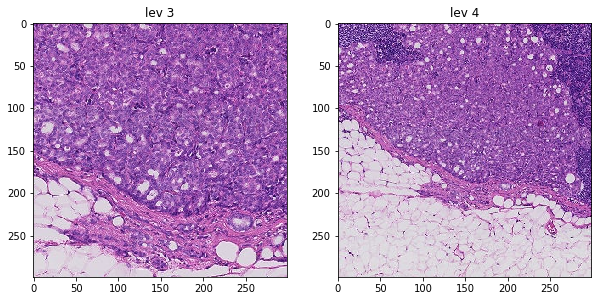

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(train_1_ilevel[0])
plt.title('lev 3')
plt.subplot(1,2,2)
plt.imshow(train_1_jlevel[0])
plt.title('lev 4')

In [0]:
# import shutil
# for ilevel in range(3,5):
#   train_dir = 'drive/My Drive/project-adl/train_level%d' %ilevel
#   if os.path.exists(train_dir):
#     shutil.rmtree(train_dir)
#   os.mkdir(train_dir)
#   train_0_dir = os.path.join(train_dir, 'patches0')
#   train_1_dir = os.path.join(train_dir, 'patches1')
#   if not os.path.exists(train_0_dir):
#     os.mkdir(train_0_dir)
#   if not os.path.exists(train_1_dir):
#     os.mkdir(train_1_dir)
#   val_dir = 'drive/My Drive/project-adl/val_level%d' %ilevel
#   if os.path.exists(val_dir):
#     shutil.rmtree(val_dir)
#   os.mkdir(val_dir)
#   val_0_dir = os.path.join(val_dir, 'patches0')
#   val_1_dir = os.path.join(val_dir, 'patches1')
#   if not os.path.exists(val_0_dir):
#     os.mkdir(val_0_dir)
#   if not os.path.exists(val_1_dir):
#     os.mkdir(val_1_dir)

### Generate training images of Lev3&lev4 

In [0]:
import shutil
for ilevel in range(3,5):
  train_dir = 'drive/My Drive/project-adl/train_selected_level%d' %ilevel
  if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
  os.mkdir(train_dir)
  train_0_dir = os.path.join(train_dir, 'patches0')
  train_1_dir = os.path.join(train_dir, 'patches1')
  if not os.path.exists(train_0_dir):
    os.mkdir(train_0_dir)
  if not os.path.exists(train_1_dir):
    os.mkdir(train_1_dir)

In [0]:
from matplotlib.image import imsave
nclass = 100
for slide_id in train_list:
  train_0_ilevel, train_1_ilevel, train_0_jlevel, train_1_jlevel=generate_train_ij(slide_id, nclass, 3, 4)
  for ilevel in range(3,5):
    train_dir = 'drive/My Drive/project-adl/train_selected_level%d' %ilevel
    train_0_dir = os.path.join(train_dir, 'patches0')
    train_1_dir = os.path.join(train_dir, 'patches1')

    if ilevel == 3:
      train_0 = train_0_ilevel
      train_1 = train_1_ilevel
    else:
      train_0 = train_0_jlevel
      train_1 = train_1_jlevel

    for i in range(len(train_0)):
      filename0 = os.path.join(train_0_dir,'tumor_%s_%d.png' %(slide_id, i))
      imsave(filename0,train_0[i])
      filename1 = os.path.join(train_1_dir,'tumor_%s_%d.png' %(slide_id, i))
      imsave(filename1,train_1[i])